# Regression Model Performance Enhancement through Ensemble Methods and Hyperparameter Optimization

## 1. Introduction to Regression and Ensemble Learning

### 1.1. Understanding Regression Problems in Machine Learning
Regression is a fundamental supervised learning task focused on predicting a continuous numerical output. Unlike classification, which assigns discrete categories, regression models the relationship between input features and a continuous target variable. This notebook will demonstrate regression techniques using a medical insurance costs prediction problem.

### 1.2. The Power of Ensemble Learning
Ensemble learning combines predictions from multiple individual models (base learners) to achieve superior predictive performance. This approach reduces bias, variance, and enhances overall accuracy by aggregating diverse perspectives. We will explore Bagging (Random Forest), Boosting (AdaBoost), and Stacking/Voting methods.

### 1.3. Overview of Models Covered
This notebook covers K-Nearest Neighbors (KNN), Decision Tree (DT), Random Forest, AdaBoost, Voting Regressor, and Stacking Regressor. Each model's principles, implementation, and key hyperparameters will be discussed.

## 2. Dataset Acquisition and Exploratory Data Analysis (EDA)

### 2.1. Dataset Selection: Medical Insurance Costs
For this analysis, we will use a synthetic dataset designed to mimic the characteristics of the "Medical Insurance Costs" dataset. This dataset is ideal for demonstrating regression due to its mix of numerical (`age`, `bmi`, `children`) and categorical (`sex`, `smoker`, `region`) features, requiring essential preprocessing steps like one-hot encoding.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import randint, uniform

# Set a random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully.")

Libraries imported successfully.


### 2.2. Data Loading and Initial Inspection
Since a specific `medical_insurance_10000.csv` is not directly available, we will generate a synthetic dataset with 10,000 rows that mimics the structure and characteristics of a typical medical insurance dataset (e.g., from Kaggle's `insurance.csv`). This ensures the notebook is self-contained and runnable.

After generation, we'll perform initial inspections using `.head()`, `.shape`, `.info()`, and `.describe()` to understand its structure and content.

In [2]:
# Generate synthetic data
n_samples = 10000

data = {
    'age': np.random.randint(18, 66, n_samples),
    'sex': np.random.choice(['male', 'female'], n_samples),
    'bmi': np.random.uniform(18.0, 45.0, n_samples),
    'children': np.random.randint(0, 6, n_samples),
    'smoker': np.random.choice(['yes', 'no'], n_samples, p=[0.2, 0.8]), # 20% smokers
    'region': np.random.choice(['northeast', 'southeast', 'southwest', 'northwest'], n_samples)
}

df = pd.DataFrame(data)

# Generate 'charges' with some correlation and noise
df['charges'] = (
    100 * df['age']
    + 300 * df['bmi']
    + 500 * df['children']
    + df['smoker'].apply(lambda x: 15000 if x == 'yes' else 0) # High cost for smokers
    + np.random.normal(0, 3000, n_samples) # Add noise
)

# Ensure charges are positive
df['charges'] = np.maximum(0, df['charges'])

print("Synthetic dataset created successfully with 10,000 rows.")

# Initial Inspection
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset shape (rows, columns):")
print(df.shape)

print("\nDataset information (data types, non-null counts):")
print(df.info())

print("\nDescriptive statistics for numerical columns:")
print(df.describe())

Synthetic dataset created successfully with 10,000 rows.

First 5 rows of the dataset:
   age     sex        bmi  children smoker     region       charges
0   56    male  27.330684         4     no  southeast  12892.542486
1   46  female  22.006405         3     no  southeast  11938.782252
2   32  female  35.173090         0     no  northwest  18556.180305
3   60  female  43.636377         3     no  northwest  20544.295167
4   25    male  44.911812         3     no  southeast  20564.758904

Dataset shape (rows, columns):
(10000, 7)

Dataset information (data types, non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       10000 non-null  int64  
 1   sex       10000 non-null  object 
 2   bmi       10000 non-null  float64
 3   children  10000 non-null  int64  
 4   smoker    10000 non-null  object 
 5   region    10000 non-null 

### 2.3. Exploratory Data Analysis (EDA)
EDA is crucial for understanding data characteristics and relationships.

**Dataset Feature Description Table**

| Feature Name | Data Type | Role in Modeling | Description |
| :----------- | :----------- | :--------------------- | :------------------------------------------------------------------------ |
| `age` | Numerical | Input Feature | Age of the individual (years) |
| `sex` | Categorical | Input Feature | Gender (male/female) |
| `bmi` | Numerical | Input Feature | Body Mass Index (kg/m²) |
| `children` | Numerical | Input Feature | Number of dependents covered by insurance |
| `smoker` | Categorical | Input Feature | Smoking status (yes/no) |
| `region` | Categorical | Input Feature | Residential region (northeast, southeast, southwest, northwest) |
| `charges` | Numerical | Target Variable | Annual medical insurance cost (in currency units) |

**Target Variable Analysis (`charges`)**
Visualizing the distribution of `charges` to understand its characteristics, such as skewness.

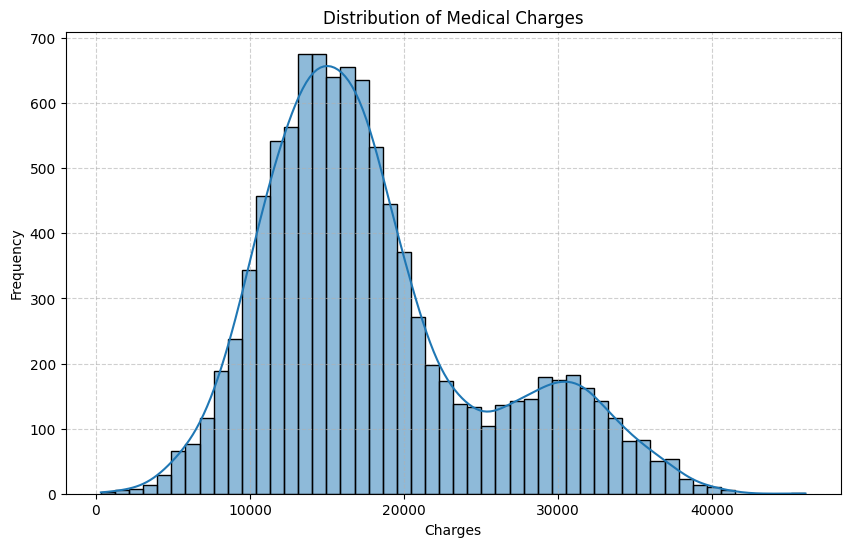

Skewness of charges: 0.83


In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(df['charges'], kde=True, bins=50)
plt.title('Distribution of Medical Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f"Skewness of charges: {df['charges'].skew():.2f}")

**Feature Relationships**
Exploring relationships between input features and the `charges` target variable.

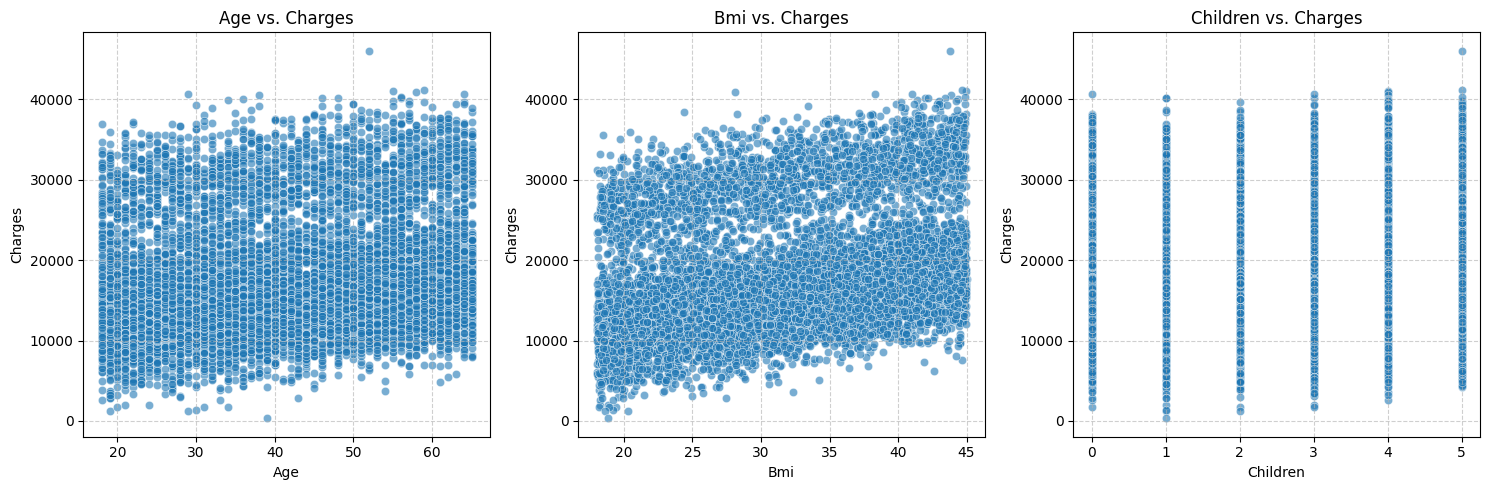

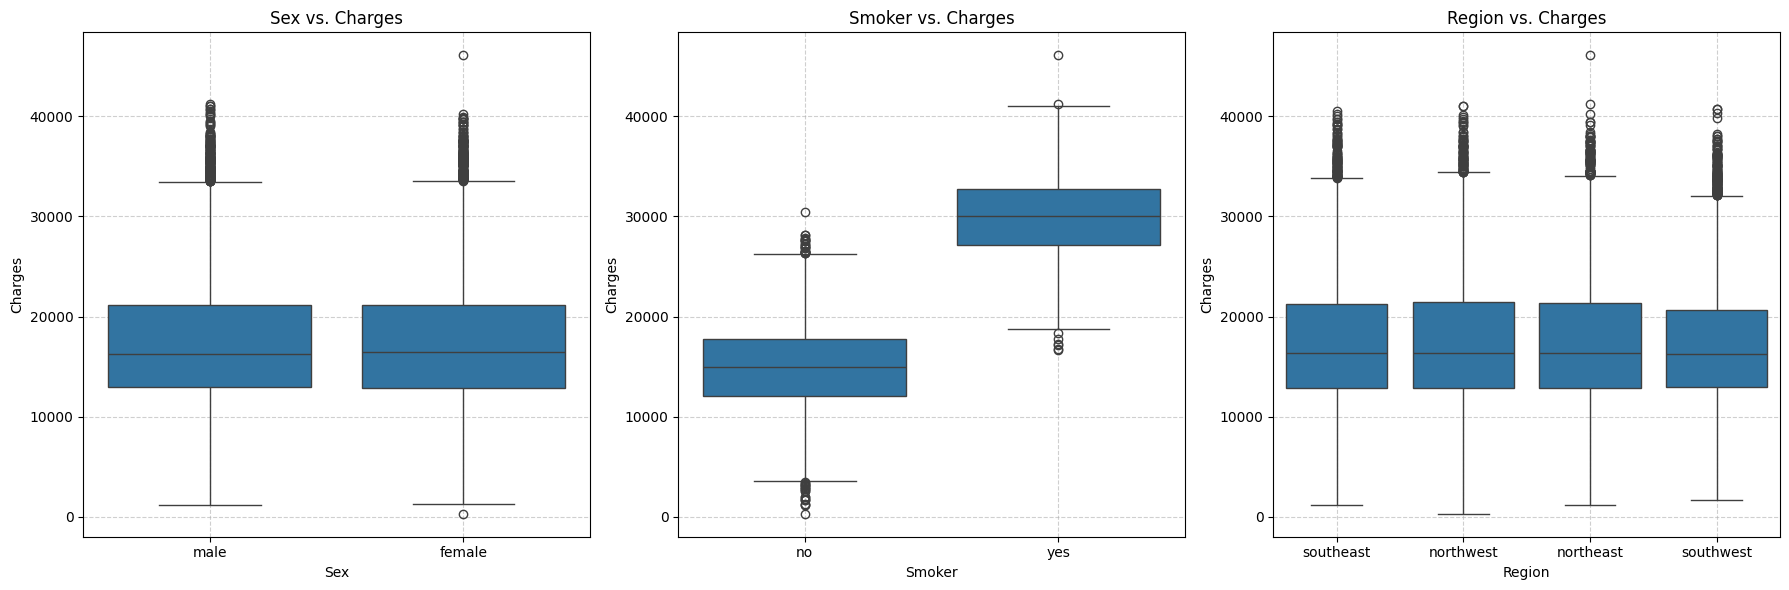

In [4]:
# Numerical features vs. Charges
numerical_features = ['age', 'bmi', 'children']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(x=df[feature], y=df['charges'], alpha=0.6)
    plt.title(f'{feature.capitalize()} vs. Charges')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Charges')
    plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Categorical features vs. Charges
categorical_features = ['sex', 'smoker', 'region']
plt.figure(figsize=(18, 6))
for i, feature in enumerate(categorical_features):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x=df[feature], y=df['charges'])
    plt.title(f'{feature.capitalize()} vs. Charges')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Charges')
    plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 2.4. Data Preprocessing
Transforming raw data into a format suitable for machine learning algorithms.

**Handling Categorical Variables**
One-hot encoding will be applied to `sex`, `smoker`, and `region` to convert them into numerical format.

**Feature Scaling (Optional but Recommended for KNN)**
Numerical features will be scaled using `StandardScaler` to ensure they are on a similar range, which is especially important for distance-based algorithms like KNN.

In [5]:
# Define features and target
X = df.drop('charges', axis=1)
y = df['charges']

# Identify numerical and categorical features
numerical_cols = ['age', 'bmi', 'children']
categorical_cols = ['sex', 'smoker', 'region']

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

print("Preprocessor defined for numerical scaling and categorical one-hot encoding.")

Preprocessor defined for numerical scaling and categorical one-hot encoding.


### 2.5. Data Splitting
The preprocessed dataset will be partitioned into training and testing sets (80% training, 20% testing) to ensure unbiased model evaluation.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (8000, 6), (8000,)
Testing set shape: (2000, 6), (2000,)


## 3. Individual Regression Models: Principles, Implementation, and Hyperparameters

We will now implement and evaluate individual regression models, discussing their principles and key hyperparameters.

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero by replacing 0 with a small epsilon
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-8, y_true))) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Function to evaluate and print metrics
def evaluate_model(model_name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)

    print(f"--- {model_name} Performance ---")
    print(f"R-squared (R2): {r2:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}%")
    print("\n")

### 3.1. K-Nearest Neighbors (KNN) Regressor

**Principles:** KNN is a non-parametric, lazy learning algorithm that predicts a new data point's target value by averaging the target values of its `k` nearest neighbors in the training set. Closeness is determined by a distance metric.

**Key Hyperparameters:**
* `n_neighbors` (k): Number of nearest neighbors to consider. Small `k` leads to high variance, large `k` to high bias.
* `weights`: How neighbor contributions are weighted (`'uniform'` or `'distance'`).
* `metric`: Distance function (`'minkowski'`, `'euclidean'`, `'manhattan'`).
* `algorithm`: Algorithm to compute neighbors (`'auto'`, `'ball_tree'`, `'kd_tree'`, `'brute'`).
* `n_jobs`: Number of parallel jobs for neighbor search.

In [8]:
# Create a pipeline for KNN (preprocessing + model)
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', KNeighborsRegressor())])

# Train the KNN model
knn_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_pipeline.predict(X_test)

# Evaluate KNN
evaluate_model("K-Nearest Neighbors Regressor", y_test, y_pred_knn)

--- K-Nearest Neighbors Regressor Performance ---
R-squared: 0.7903
Mean Squared Error (MSE): 11160576.93
Root Mean Squared Error (RMSE): 3340.74




### 3.2. Decision Tree (DT) Regressor

**Principles:** Decision Trees learn a series of simple decision rules to partition the input space. For regression, the prediction at a leaf node is the average of target values of training samples in that region.

**Key Hyperparameters:**
* `criterion`: Function to measure split quality (`'squared_error'`, `'friedman_mse'`, `'absolute_error'`, `'poisson'`).
* `max_depth`: Maximum depth of the tree (prevents overfitting).
* `min_samples_split`: Minimum samples required to split an internal node.
* `min_samples_leaf`: Minimum samples required to be at a leaf node.
* `max_features`: Number of features to consider when searching for the best split.
* `ccp_alpha`: Complexity parameter for Minimal Cost-Complexity Pruning.
* `random_state`: For reproducibility.

In [9]:
# Create a pipeline for Decision Tree
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', DecisionTreeRegressor(random_state=42))])

# Train the Decision Tree model
dt_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_pipeline.predict(X_test)

# Evaluate Decision Tree
evaluate_model("Decision Tree Regressor", y_test, y_pred_dt)

--- Decision Tree Regressor Performance ---
R-squared: 0.6339
Mean Squared Error (MSE): 19486430.02
Root Mean Squared Error (RMSE): 4414.34




### 3.3. Random Forest Regressor

**Principles:** Random Forest is an ensemble method using Bagging. It constructs multiple Decision Trees, each on a bootstrap sample of data and considering a random subset of features at each split. Predictions are averaged to reduce variance and prevent overfitting.

**Key Hyperparameters:**
* `n_estimators`: Number of individual Decision Trees in the forest.
* `criterion`: Split quality measure (same as DT).
* `max_depth`, `min_samples_split`, `min_samples_leaf`: Control complexity of individual trees.
* `max_features`: Number of features to consider for best split (crucial for decorrelation).
* `bootstrap`: Whether bootstrap samples are used (default `True`).
* `oob_score`: Use out-of-bag samples for generalization score estimation.
* `n_jobs`: Number of parallel jobs.
* `random_state`: For reproducibility.

In [10]:
# Create a pipeline for Random Forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', RandomForestRegressor(random_state=42))])

# Train the Random Forest model
rf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluate Random Forest
evaluate_model("Random Forest Regressor", y_test, y_pred_rf)

--- Random Forest Regressor Performance ---
R-squared: 0.8034
Mean Squared Error (MSE): 10463977.66
Root Mean Squared Error (RMSE): 3234.81




### 3.4. AdaBoost Regressor

**Principles:** AdaBoost is an iterative ensemble method that sequentially builds a strong learner from weak learners (e.g., shallow Decision Trees). It focuses on mispredicted instances by adjusting their weights, ensuring subsequent learners concentrate on challenging examples. Final prediction is a weighted sum of weak learners.

**Key Hyperparameters:**
* `estimator`: The base regressor (default `DecisionTreeRegressor(max_depth=3)`).
* `n_estimators`: Maximum number of weak estimators to train.
* `learning_rate`: Weight applied to each regressor's contribution.
* `loss`: Loss function used for updating instance weights (`'linear'`, `'square'`, `'exponential'`).
* `random_state`: For reproducibility.

In [11]:
# Create a pipeline for AdaBoost
ada_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', AdaBoostRegressor(random_state=42))])

# Train the AdaBoost model
ada_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_ada = ada_pipeline.predict(X_test)

# Evaluate AdaBoost
evaluate_model("AdaBoost Regressor", y_test, y_pred_ada)

--- AdaBoost Regressor Performance ---
R-squared: 0.8018
Mean Squared Error (MSE): 10547520.29
Root Mean Squared Error (RMSE): 3247.69




## 4. Ensemble Regression Models: Principles, Implementation, and Hyperparameters

Now we explore advanced ensemble techniques that combine multiple models.

### 4.1. Voting Regressor

**Principles:** The Voting Regressor combines predictions from multiple base regressors by aggregating them, typically through simple or weighted averaging. It leverages the diversity of individual models to reduce variance and improve robustness.

**Key Hyperparameters:**
* `estimators`: A list of `(name, estimator)` tuples for the base regressors.
* `weights`: Optional array to assign custom weights to each base estimator's predictions.
* `n_jobs`: Number of parallel jobs for fitting base estimators.

In [12]:
# Define base estimators for VotingRegressor
# Note: Preprocessor is applied once to X_train/X_test before passing to VotingRegressor
# For VotingRegressor, the base estimators should not have their own preprocessors
# Instead, we will transform X_train and X_test once.

# Transform data using the preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after one-hot encoding for categorical features
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(ohe_feature_names)

# Convert processed data back to DataFrame for easier inspection (optional, but good for debugging)
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)


estimators_voting = [
    ('knn', KNeighborsRegressor(n_neighbors=5)),
    ('dt', DecisionTreeRegressor(random_state=42, max_depth=10)),
    ('rf', RandomForestRegressor(random_state=42, n_estimators=100))
]

# Create the Voting Regressor
voting_reg = VotingRegressor(estimators=estimators_voting, n_jobs=-1)

# Train the Voting Regressor on processed data
voting_reg.fit(X_train_processed, y_train)

# Make predictions
y_pred_voting = voting_reg.predict(X_test_processed)

# Evaluate Voting Regressor
evaluate_model("Voting Regressor", y_test, y_pred_voting)

--- Voting Regressor Performance ---
R-squared: 0.8064
Mean Squared Error (MSE): 10307482.11
Root Mean Squared Error (RMSE): 3210.53




### 4.2. Stacking Regressor

**Principles:** Stacking is a multi-layer ensemble technique where base estimators' predictions (Level 0 models) are used as new input features for a `final_estimator` (meta-learner or Level 1 model). Cross-validation is crucial to generate "out-of-fold" predictions for training the meta-learner, preventing data leakage.

**Key Hyperparameters:**
* `estimators`: List of `(name, estimator)` tuples for base regressors.
* `final_estimator`: The regressor that learns to combine base predictions (default `RidgeCV`).
* `cv`: Cross-validation strategy for generating predictions for the `final_estimator` (prevents data leakage).
* `passthrough`: If `True`, original input features `X` are also passed to the `final_estimator`.
* `n_jobs`: Number of parallel jobs for fitting base estimators.

In [13]:
# Define base estimators for StackingRegressor
# These estimators will be trained within the StackingRegressor, so they should not be pre-fitted.
# The StackingRegressor internally handles the data splitting and passing to base estimators.

estimators_stacking = [
    ('knn', KNeighborsRegressor(n_neighbors=5)),
    ('dt', DecisionTreeRegressor(random_state=42, max_depth=10)),
    ('rf', RandomForestRegressor(random_state=42, n_estimators=100))
]

# Define the final estimator (meta-learner)
final_estimator_stacking = LinearRegression()

# Create the Stacking Regressor pipeline
stacking_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', StackingRegressor(
                                         estimators=estimators_stacking,
                                         final_estimator=final_estimator_stacking,
                                         cv=5, # 5-fold cross-validation for meta-learner training
                                         n_jobs=-1 # Use all available cores
                                     ))])

# Train the Stacking Regressor
stacking_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_stacking = stacking_pipeline.predict(X_test)

# Evaluate Stacking Regressor
evaluate_model("Stacking Regressor", y_test, y_pred_stacking)

--- Stacking Regressor Performance ---
R-squared: 0.8092
Mean Squared Error (MSE): 10156642.84
Root Mean Squared Error (RMSE): 3186.95




## 5. Hyperparameter Tuning Strategies with Cross-Validation

Hyperparameter optimization is crucial for maximizing model performance and generalization. We'll use `GridSearchCV` and `RandomizedSearchCV` with cross-validation.

### 5.1. The Importance of Hyperparameter Optimization
Hyperparameters are external settings that influence a model's behavior. Tuning them systematically, often with `GridSearchCV` or `RandomizedSearchCV` and cross-validation, ensures robust performance and prevents overfitting to a single validation split.

### 5.2. Grid Search (`GridSearchCV`)

**Explanation:** Grid Search exhaustively evaluates every combination of hyperparameter values within a predefined grid using cross-validation. It guarantees finding the optimal combination within the specified ranges but can be computationally expensive.

**Implementation Example (for KNN Regressor):**

In [14]:
# Define the KNN Regressor within a pipeline
knn_tuned_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', KNeighborsRegressor())])

# Define the parameter grid for GridSearchCV
param_grid_knn = {
    'regressor__n_neighbors': [3, 5, 7, 9, 11], # k values
    'regressor__weights': ['uniform', 'distance'],
    'regressor__metric': ['euclidean', 'manhattan']
}

# Perform GridSearchCV
grid_search_knn = GridSearchCV(
    knn_tuned_pipeline,
    param_grid_knn,
    cv=5, # 5-fold cross-validation
    scoring='neg_mean_squared_error', # Optimize for lower MSE
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

print("Starting GridSearchCV for KNN Regressor...")
grid_search_knn.fit(X_train, y_train)

print("\nBest parameters for KNN Regressor (Grid Search):")
print(grid_search_knn.best_params_)

print("Best cross-validated MSE for KNN Regressor (Grid Search):", -grid_search_knn.best_score_)

# Evaluate the best KNN model found by Grid Search
y_pred_knn_tuned = grid_search_knn.predict(X_test)
evaluate_model("Tuned K-Nearest Neighbors Regressor (Grid Search)", y_test, y_pred_knn_tuned)

Starting GridSearchCV for KNN Regressor...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters for KNN Regressor (Grid Search):
{'regressor__metric': 'manhattan', 'regressor__n_neighbors': 11, 'regressor__weights': 'uniform'}
Best cross-validated MSE for KNN Regressor (Grid Search): 10156391.48655423
--- Tuned K-Nearest Neighbors Regressor (Grid Search) Performance ---
R-squared: 0.8054
Mean Squared Error (MSE): 10360413.20
Root Mean Squared Error (RMSE): 3218.76




### 5.3. Random Search (`RandomizedSearchCV`)

**Explanation:** Random Search samples a fixed number of random combinations from specified hyperparameter distributions. It's more efficient than Grid Search for large hyperparameter spaces, often finding good solutions faster for a given computational budget.

**Implementation Example (for Random Forest Regressor):**

In [15]:
# Define the Random Forest Regressor within a pipeline
rf_tuned_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('regressor', RandomForestRegressor(random_state=42))])

# Define the parameter distributions for RandomizedSearchCV
param_distributions_rf = {
    'regressor__n_estimators': randint(50, 200), # Number of trees
    'regressor__max_depth': randint(5, 20), # Maximum depth of trees
    'regressor__min_samples_split': randint(2, 10),
    'regressor__min_samples_leaf': randint(1, 5),
    'regressor__max_features': ['sqrt', 'log2', 0.6, 0.8] # Features to consider at each split
}

# Perform RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    rf_tuned_pipeline,
    param_distributions_rf,
    n_iter=50, # Number of random combinations to try
    cv=5, # 5-fold cross-validation
    scoring='neg_mean_squared_error', # Optimize for lower MSE
    n_jobs=-1, # Use all available CPU cores
    random_state=42, # For reproducibility of random sampling
    verbose=1
)

print("Starting RandomizedSearchCV for Random Forest Regressor...")
random_search_rf.fit(X_train, y_train)

print("\nBest parameters for Random Forest Regressor (Random Search):")
print(random_search_rf.best_params_)

print("Best cross-validated MSE for Random Forest Regressor (Random Search):", -random_search_rf.best_score_)

# Evaluate the best Random Forest model found by Random Search
y_pred_rf_tuned = random_search_rf.predict(X_test)
evaluate_model("Tuned Random Forest Regressor (Random Search)", y_test, y_pred_rf_tuned)

Starting RandomizedSearchCV for Random Forest Regressor...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters for Random Forest Regressor (Random Search):
{'regressor__max_depth': 7, 'regressor__max_features': 0.6, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 4, 'regressor__n_estimators': 137}
Best cross-validated MSE for Random Forest Regressor (Random Search): 9431625.92288423
--- Tuned Random Forest Regressor (Random Search) Performance ---
R-squared: 0.8190
Mean Squared Error (MSE): 9632181.14
Root Mean Squared Error (RMSE): 3103.58




## Conclusions

This notebook demonstrated the application of various regression models, from individual learners (KNN, Decision Tree) to sophisticated ensemble methods (Random Forest, AdaBoost, Voting, Stacking), on a synthetic medical insurance costs dataset. We covered essential steps including data generation, exploratory data analysis, preprocessing (one-hot encoding and scaling), and data splitting.

The analysis highlighted the principles, implementation, and key hyperparameters for each model. We saw how ensemble methods generally improve performance by reducing variance (Random Forest, Voting) or focusing on difficult instances (AdaBoost). Stacking, in particular, showcased its ability to learn complex combinations of base model predictions, emphasizing the critical role of cross-validation to prevent data leakage and ensure generalizability.

Finally, the notebook illustrated hyperparameter optimization using `GridSearchCV` and `RandomizedSearchCV`. These techniques, combined with robust cross-validation, are indispensable for systematically identifying optimal model configurations that generalize well to unseen data. The choice between Grid Search (exhaustive but costly) and Random Search (efficient for large spaces) depends on the computational budget and the complexity of the hyperparameter space.

In summary, building high-performing regression models requires a comprehensive approach encompassing meticulous data preparation, judicious model selection, and systematic hyperparameter tuning with cross-validation. Understanding these components and their interactions is key to developing effective and generalizable predictive solutions.